# <a id='toc1_'></a>[深層学習ノートブック-13 DatasetとDataLoader](#toc0_)
Pytorchにおいて、学習用のデータセットを読み込んだり前処理を効率的に行う仕組み。  
* Dataset
    * torch.utils.data.Dataset
    * pytorchには既にいくつものDatasetが用意されている
        * https://pytorch.org/vision/stable/datasets.html
    * カスタムで作ることも可能
        * torch.uDls.data.Datasetを継承する
        * __len__と__getitem__をオーバーライドする。

* DataLoader
    * torch.utils.data.DataLoader
    * Datasetからバッチ単位でデータを効率的に読み込むためのイテレータを提供
    * 複数のスレッドによる並列処理に対応している
        * 深層学習において、GPUは学習に関する処理、CPUはディスクにあるデータをミニバッチ単位で読み込みを行っている。  
        CPUによるデータ（ミニバッチ）の読み込みがGPUの学習よりも遅いと、GPUがデータ読み込み待ちになってしまい、タイムロスが生じる。  
        DataLoaderはミニバッチをCPUから並列で読み込むことで、データ読み込み時間の短縮を図ることが出来る。

参考：  
* [Udemy講座：「①米国AI開発者がやさしく教える深層学習超入門第一弾【Pythonで実践】」](https://www.udemy.com/course/deeplearning1/learn/lecture/40143418)

**Table of contents**<a id='toc0_'></a>    
- [深層学習ノートブック-13 DatasetとDataLoader](#toc1_)    
  - [■ Pytorchが提供するMNISTデータのDatasetを使う](#toc1_1_)    
    - [Transform](#toc1_1_1_)    
  - [■ DataLoaderでDatasetからデータを読み込む](#toc1_2_)    
  - [■ DataLoaderをMLPの学習ループに組み込む](#toc1_3_)    
    - [●学習曲線の描画](#toc1_3_1_)    
    - [※余計なコメントアウトを除いた場合の全ソースコード](#toc1_3_2_)    
  - [※余計なコメントアウトを除いた場合の全ソースコード](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[■ Pytorchが提供するMNISTデータのDatasetを使う](#toc0_)
* torchvisionというPytorchと互換性があるCVのためのライブラリを用いる。
* MNISTデータはtorchvision.datasetsのうちの一つのDatasetクラス。  
* 使い方
    * torchvision.datasets.MNISTクラスでインスタンスを生成
        * root: データを保存するディレクトリを指定
        * train: Trueなら学習データを，Falseならテストデータをロード
        * download: Trueなら，rootに指定したディレクトリにダウンロードし，  
            既にデータがある場合はそのデータを使用する
    * []でindexingによりデータとラベルをtuple形式で取得する．
    * データはPIL(Pillow)で返ってくるので，tensorへtransformが必要

In [7]:
import sys

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [46]:
# MNISTの学習データを./mnist_dataへダウンロード
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True)

In [47]:
# サイズを確認すると５６バイトしかない。
# train_datasetにダウンロードしたデータが入るわけではない。実態はあくまでディスクにある。
sys.getsizeof(train_dataset)

56

In [48]:
len(train_dataset)

60000

データ自体は60000件あることが分かる。

In [49]:
# データとラベル（目的変数）をtupleで取得
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [50]:
# １枚目の画像と正解ラベルを格納
image, label = train_dataset[0]

In [51]:
# データを確認
image

In [52]:
# 正解ラベル
label

5

PIL形式はJupyterLabではそのまま描画できる。  
もちろん下記のようにmatplotlibでも可能。

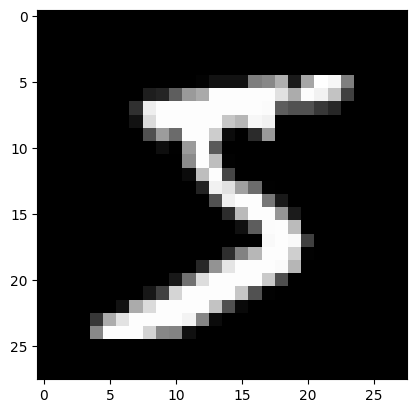

In [53]:
plt.imshow(image, cmap='gray')

### <a id='toc1_1_1_'></a>[Transform](#toc0_)
Datasetで読み込んだデータセット（PIL）をTensorに変換したり、  
標準化・正規化等の前処理出来るモジュール。

* torchvision.transforms: 画像関連で使用する便利な変換機能を提供
    * __.ToTensor()__: [0, 255]の(H, W, C(=Channel))のPILやNumpyArrayをtensorに変換するクラス
        * インスタンスを生成しPIL形式のデータを渡してcallする
        * 変換後は[0., 1.]の(C, H, W)のtensorとなる
    * __.Normalize()__: 平均と標準偏差を使って画像データを標準化する
        * mean: それぞれのchannelのmeanをtupleで渡す
        * std: それぞれのchannelのstdをtupleで渡す
        * 正規化として使われることが多い (0~1 -> -1~1)
    * __.Compose()__: 複数のtransformをまとめる
        * 複数のtransformsのインスタンスをリストにして渡す
        * datasets.<クラス名>のtransform引数に渡すことで，データをロードする際に変換処理を行ってくれる


In [54]:
# DatasetをTensorに変換。一度ToTensorのインスタンスを作ってからimageを渡してcallする
image_tensor = transforms.ToTensor()(image)
image_tensor.shape

torch.Size([1, 28, 28])

In [55]:
image_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

Tensorに変換されている。

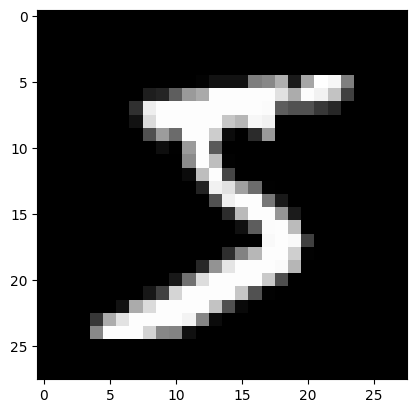

In [56]:
# チャネルファースト(C, H, W)になっているので、そのままimshowには入れられないため、2Rankにして渡している。
plt.imshow(image_tensor[0], cmap='gray')

In [57]:
# 標準化.平均と標準偏差を決め打ちでタプルで渡すことに注意
normalized_image_tensor = transforms.Normalize((0.5, ), (0.5) )(image_tensor)
normalized_image_tensor

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

ToTensorで変換後のTensorは0,1の値を持つので、平均・標準偏差0.5を指定すると、  
-1,1で正規化される。これは深層学習の前処理としてよく使われるテクニックである。

In [58]:
# .Compose()でTensorへの変換と標準化をまとめてできる
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,) , (0.5,))
])


In [59]:
transform(image)

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

上記のようにリストとして、操作を渡すことで前処理をまとめて実行してくれる。

In [60]:
# datasets読み込みの際にtransform引数に渡すことで前処理された状態でデータを利用できる
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)

In [61]:
image, label = train_dataset[0]
image

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

train=Falseにして読み込めば、学習データと同じ前処理を検証データにも適用できる。

## <a id='toc1_2_'></a>[■ DataLoaderでDatasetからデータを読み込む](#toc0_)
上記で作成したtrain_datasetとval_datasetからデータを読み込む。  

* torch.utils.data.DataLoaderクラスでインスタンスを生成
    * dataset: ロード対象となるDatasetオブジェクトを指定
    * batch_size: ミニバッチ学習におけるバッチサイズ
    * shuffle: Trueの場合，各epochでシャッフルする
    * 検証データの場合，shuffleは不要
    * num_workers: データロードに使用するスレッドの数

In [62]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=10,  num_workers=2)

DataLoaderはGeneratorの形で返ってくるので、イテレーションが可能。  

In [63]:
next(iter(train_loader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

イテレーションを実行すると、10個のデータ（バッチサイズと同じ）とその教師ラベルが返ってくる。  

In [64]:
# バッチを一つ取り出す
images, labels = next(iter(train_loader))
print(images.shape)

torch.Size([10, 1, 28, 28])


バッチサイズ、チャネル数、画像の高さ、画像の幅のシェイプ(b, c, h, w)となっている。  
画像データを直接扱えるようなモデルはこのシェイプのデータを学習データとすることが多い。  

In [65]:
# plt.imshowで可視化するために、Rank3のtensorに変換する
grid_images = torchvision.utils.make_grid(images)
grid_images.shape

torch.Size([3, 62, 242])

make_gridを(b, c, h, w)の画像データに適用すると、  
Rank3のtensorに変換されるが、(c, h, w)の形式で返されるので、  
imshowで可視化するために(h, w, c)に変換する必要あり。

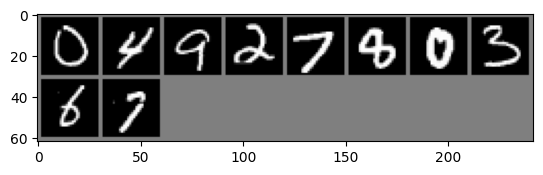

In [66]:
# 今、imagesは正規化して読み込んでいるので、正規化前に戻して生の状態を可視化(z = (x-平均)/標準偏差を変形してxについて解く。)
grid_images = 0.5 * (grid_images + 1.0) 

plt.imshow(torch.permute(grid_images, (1, 2, 0)))

In [67]:
# 対応するラベルを見る
labels

tensor([0, 4, 9, 2, 7, 8, 0, 3, 6, 7])

## <a id='toc1_3_'></a>[■ DataLoaderをMLPの学習ループに組み込む](#toc0_)
これまでのMLPの実装ではsklearnのdatasetモジュールからデータを読み込み、  
それをミニバッチサイズに切り出し、シャッフルして学習・検証に使用していた。  
この流れはDatasetとDataLoaderを用いることで簡略化できる。  

In [2]:
class MLP_1(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        # 親クラスのinitを呼び出す。
        super().__init__()
        # nn.Flattenにより[b, c, h, w] -> [b, c x h x w]（ミニバッチサイズ, 画像の特徴量数の積）に変換
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(num_in, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_out)

    # nn.Moduleにもforwardメソッドがあり、ここでオーバーライドしている。
    def forward(self, x):
        # 最初の全結合層の計算に渡す際にnn.Flattenを実行しておく必要あり。
        z = self.linear_2( F.relu( self.linear_1(self.flatten(x))) )
        return z

補足：なぜ c x h x wの形状にするのか  
DataLoaderで返されるデータの形状は[b, c, h, w]なので、nn.Linearで線形変換するためには、  
入力データをRank2に変換する必要があるため。  
nn.Linearに渡すデータ$X$のRank1は学習データの数であり、Rank2は特徴量数に相当するのであったから、  
画像データにおける特徴量数＝チャネル数×縦サイズ×横サイズをのshapeを渡す必要がある。  
nn.Flattenは画像の学習によく使うので覚えておくとよい。基本的にDataLoaderから画像データを読み込んだ時は  
全結合層の前にnn.Flattenが必要になる。

In [3]:
# バッチサイズを定義。今回は１ミニバッチ＝３２データとする
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,) , (0.5,))
])

# datasets読み込みの際にtransform引数に渡してまとめて前処理しておく。
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,  num_workers=2)

In [139]:
# MNISTデータセットの読み込み
# dataset = datasets.load_digits()
# X = torch.tensor( dataset.data , dtype=torch.float32) 
# y = torch.tensor( dataset.target)
# # ★ F.cross_entropyの仕様的にはone_hotの形にする必要はない
# # y = F.one_hot(y, num_classes=10) 

# # hold-out
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # 標準化
# train_mean, train_std = X_train.mean(), X_train.std()
# X_train = (X_train - train_mean) / train_std
# X_val = (X_val - train_mean) / train_std

# モデルのコンストラクタに渡す引数を定義。今回の特徴量数はチャネル数×縦サイズ×横サイズ
num_in = 28 * 28 * 1
num_hidden = 30
num_out = 10

DataLoaderを活用することにより、上記のような標準化やデータセットの読み込み(コメントアウト部)の実装が不要になる。

In [140]:
# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)
# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
optim_torch = optim.SGD(MLP_model.parameters(), lr=0.03)

In [141]:
# num_batches = X_train.shape[0] // batch_size + 1

# 学習・検証結果格納用辞書
train_results = {}

for i, _ in enumerate(range(10)): # <- 今回はデータサイズが大きいので10エポック程度にする
    #　インデックスをシャッフル
    # shuffled_indices = np.random.permutation(len(y_train))
    
    # shuffled_indicesからの取り出し範囲初期化
    # idx_start = 0
    # idx_end = batch_size

    # 各バッチでの学習データと検証データに対するloss、accuracyを累積する用の変数
    cum_loss = 0
    cum_loss_val = 0
    cum_accuracy_val = 0

    # for _ in range(num_batches):
    for num_batches, train_data in enumerate(train_loader):
        # indices_train = shuffled_indices[ idx_start:idx_end ]
        # X_train_batch = X_train[indices_train]
        # y_train_batch = y_train[indices_train]
        # 学習データ定義
        X_train_batch, y_train_batch = train_data

        # 順伝播の計算
        y_pred = MLP_model(X_train_batch)

        # 損失計算
        loss = F.cross_entropy(y_pred , y_train_batch)
        cum_loss += loss.item()
        # 逆伝播の計算
        loss.backward()

        # パラメタ更新
        optim_torch.step()

        # 勾配初期化
        optim_torch.zero_grad()

        # 取り出し範囲更新
        # idx_start += batch_size
        # idx_end += batch_size
    

    # 検証データに対する損失を計算。こちらもバッチ単位で評価するように変更。（検証データ数が多いときはこの方が効率的）
    with torch.no_grad():
        for num_batches, val_data in enumerate(train_loader):
            X_val, y_val = val_data
            y_pred_val = MLP_model(X_val)
            loss_val = F.cross_entropy(y_pred_val, y_val)
            accuracy_val = ( (torch.argmax(y_pred_val, dim=1) == y_val).sum() / len(y_val) )
            # バッチごとの損失、accuracyを累積
            cum_loss_val += loss_val.item()
            cum_accuracy_val += accuracy_val.item()


    # 損失、accuracyを記録。
    # DataLoaderからのイテレーションの数＋１が実際のミニバッチ数になるので、累積した損失等をこれで割ってepochごとに計算
    train_results[f"epoch_{i}"] = {
        "Loss_train": cum_loss / (num_batches + 1),
        "Loss_val": cum_loss_val / (num_batches + 1),
        "Accuracy": cum_accuracy_val / (num_batches + 1),
    }

    print(f'epoch_{i}: {train_results[f"epoch_{i}"]}')


epoch_0: {'Loss_train': 0.42282983380357425, 'Loss_val': 0.2821720995446046, 'Accuracy': 0.9164166666666667}
epoch_1: {'Loss_train': 0.24643590945104757, 'Loss_val': 0.20360132475395998, 'Accuracy': 0.9409666666666666}
epoch_2: {'Loss_train': 0.1976209781785806, 'Loss_val': 0.18839373331169287, 'Accuracy': 0.94745}
epoch_3: {'Loss_train': 0.1712768629645308, 'Loss_val': 0.1708592753355702, 'Accuracy': 0.9468}
epoch_4: {'Loss_train': 0.15356849259932837, 'Loss_val': 0.13422667852193118, 'Accuracy': 0.9604333333333334}
epoch_5: {'Loss_train': 0.14071394732793172, 'Loss_val': 0.1336185780207316, 'Accuracy': 0.9610833333333333}
epoch_6: {'Loss_train': 0.1318120582698534, 'Loss_val': 0.12095829557776451, 'Accuracy': 0.9641166666666666}
epoch_7: {'Loss_train': 0.12216761567865808, 'Loss_val': 0.11329561404933532, 'Accuracy': 0.9668666666666667}
epoch_8: {'Loss_train': 0.11685490093939006, 'Loss_val': 0.11896603883455197, 'Accuracy': 0.9630333333333333}
epoch_9: {'Loss_train': 0.1094331472481

上記のようにDataLoaderを利用することにより、データからミニバッチを切り出したり、インデックス操作を行うコードが不要になり、  
非常に簡潔に学習ループを実装できる。

### <a id='toc1_3_1_'></a>[●学習曲線の描画](#toc0_)
学習データと検証データでの損失の推移を確認してみる。

In [156]:
loss_per_epoch_train = []
loss_per_epoch_val = []

for result in train_results.values():
    loss_per_epoch_train.append(result['Loss_train'])
    loss_per_epoch_val.append(result['Loss_val'])

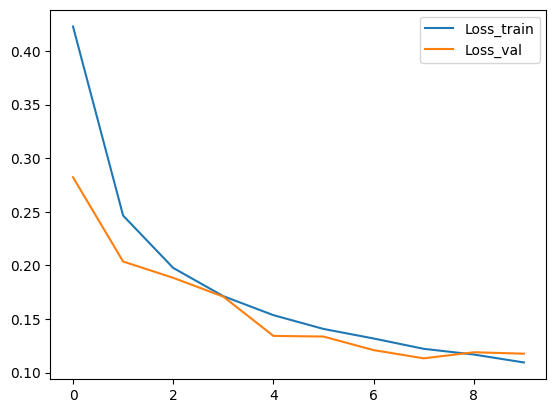

In [159]:
plt.plot(loss_per_epoch_train, label="Loss_train")
plt.plot(loss_per_epoch_val, label="Loss_val")
plt.legend()

train,valどちらも損失が下がっていっており、学習が進んでいることが分かる。

### <a id='toc1_3_2_'></a>[※余計なコメントアウトを除いた場合の全ソースコード](#toc0_)
上から実行していけば２層のMLPの学習が可能。

In [ ]:
import sys

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
class MLP_1(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        # 親クラスのinitを呼び出す。
        super().__init__()
        # nn.Flattenにより[b, c, h, w] -> [b, c x h x w]（ミニバッチサイズ, 画像の特徴量数の積）に変換
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(num_in, num_hidden)
        self.linear_2 = nn.Linear(num_hidden, num_out)

    # nn.Moduleにもforwardメソッドがあり、ここでオーバーライドしている。
    def forward(self, x):
        # 最初の全結合層の計算に渡す際にnn.Flattenを実行しておく必要あり。
        z = self.linear_2( F.relu( self.linear_1(self.flatten(x))) )
        return z

In [ ]:
# バッチサイズを定義。今回は１ミニバッチ＝３２データとする
batch_size = 32

# Datasetに対する前処理の定義
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,) , (0.5,))
])

# datasets読み込みの際にtransform引数に渡してまとめて前処理しておく。
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,  num_workers=2)

# モデルのコンストラクタに渡す引数を定義。今回の特徴量数はチャネル数×縦サイズ×横サイズ
num_in = 28 * 28 * 1
num_hidden = 30
num_out = 10
# モデル定義（２層のMLP）
MLP_model = MLP_1(num_in=num_in, num_hidden=num_hidden, num_out=num_out)
# requires_grad_をTrueに設定。最後に_がつくのは設定するという意味。
MLP_model.requires_grad_(True)

# torch.optimを使ってOptimizerを定義
optim_torch = optim.SGD(MLP_model.parameters(), lr=0.03)

In [ ]:
# 学習・検証結果格納用辞書
train_results = {}

for i, _ in enumerate(range(10)): # <- 今回はデータサイズが大きいので10エポック程度にする

    # 各バッチでの学習データと検証データに対するloss、accuracyを累積する用の変数
    cum_loss = 0
    cum_loss_val = 0
    cum_accuracy_val = 0

    for num_batches, train_data in enumerate(train_loader):
        # 学習データ定義
        X_train_batch, y_train_batch = train_data

        # 順伝播の計算
        y_pred = MLP_model(X_train_batch)
        loss = F.cross_entropy(y_pred , y_train_batch)
        cum_loss += loss.item()
        
        # 逆伝播の計算、パラメタ更新
        loss.backward()
        optim_torch.step()
        optim_torch.zero_grad()

    # 検証データに対する損失を計算。こちらもバッチ単位で評価するように変更。（検証データ数が多いときはこの方が効率的）
    with torch.no_grad():
        for num_batches, val_data in enumerate(train_loader):
            X_val, y_val = val_data
            y_pred_val = MLP_model(X_val)
            loss_val = F.cross_entropy(y_pred_val, y_val)
            accuracy_val = ( (torch.argmax(y_pred_val, dim=1) == y_val).sum() / len(y_val) )
            # バッチごとの損失、accuracyを累積
            cum_loss_val += loss_val.item()
            cum_accuracy_val += accuracy_val.item()


    # 損失、accuracyを記録。
    # DataLoaderからのイテレーションの数＋１が実際のミニバッチ数になるので、累積した損失等をこれで割ってepochごとに計算
    train_results[f"epoch_{i}"] = {
        "Loss_train": cum_loss / (num_batches + 1),
        "Loss_val": cum_loss_val / (num_batches + 1),
        "Accuracy": cum_accuracy_val / (num_batches + 1),
    }

    print(f'epoch_{i}: {train_results[f"epoch_{i}"]}')


epoch_0: {'Loss_train': 0.42282983380357425, 'Loss_val': 0.2821720995446046, 'Accuracy': 0.9164166666666667}
epoch_1: {'Loss_train': 0.24643590945104757, 'Loss_val': 0.20360132475395998, 'Accuracy': 0.9409666666666666}
epoch_2: {'Loss_train': 0.1976209781785806, 'Loss_val': 0.18839373331169287, 'Accuracy': 0.94745}
epoch_3: {'Loss_train': 0.1712768629645308, 'Loss_val': 0.1708592753355702, 'Accuracy': 0.9468}
epoch_4: {'Loss_train': 0.15356849259932837, 'Loss_val': 0.13422667852193118, 'Accuracy': 0.9604333333333334}
epoch_5: {'Loss_train': 0.14071394732793172, 'Loss_val': 0.1336185780207316, 'Accuracy': 0.9610833333333333}
epoch_6: {'Loss_train': 0.1318120582698534, 'Loss_val': 0.12095829557776451, 'Accuracy': 0.9641166666666666}
epoch_7: {'Loss_train': 0.12216761567865808, 'Loss_val': 0.11329561404933532, 'Accuracy': 0.9668666666666667}
epoch_8: {'Loss_train': 0.11685490093939006, 'Loss_val': 0.11896603883455197, 'Accuracy': 0.9630333333333333}
epoch_9: {'Loss_train': 0.1094331472481

## <a id='toc1_4_'></a>[■ カスタムのDatasetを作成する](#toc0_)
当然だが、実業務においてはライブラリのプリセットのデータセットではなく、  
業務のデータを学習に使用することが多いので、目的に合わせてカスタムのDatasetを作成する必要がある。


In [6]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None) -> None:
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self): #lenを適用したときの挙動を定義
        return len(self.X)
    
    def __getitem__(self, idx): #indexingしたときの挙動
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)
        
        return X, y

In [23]:
X = dataset['images']

In [28]:
# とりあえず下記データが手持ちにあると仮定してカスタムDatasetの動作確認する。
dataset = datasets.load_digits()
X = dataset['images']
X = ( X * (255. / 16.) ).astype(np.uint8) # 下記補足参照
y = dataset['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

* 補足  
ToTensorは0~255の範囲を0~1に変換する操作なので、0~16となっているdataset['images']の範囲を0~255に変換しておく必要あり

In [19]:
# 上記データをカスタムDatasetとして読み込み
train_my_data_set = MyDataset(X_train, y_train)

In [20]:
print(len(train_my_data_set))
print(train_my_data_set[0])

1437
(array([[ 0.,  0.,  3., 14.,  1.,  0.,  0.,  0.],
       [ 0.,  0., 12., 12.,  0.,  0.,  0.,  0.],
       [ 0.,  3., 16.,  6.,  0.,  0.,  0.,  0.],
       [ 0.,  5., 16.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  6., 16.,  2.,  5.,  2.,  0.,  0.],
       [ 0.,  4., 16.,  2., 12., 15.,  2.,  0.],
       [ 0.,  1., 14., 13.,  2., 13., 11.,  0.],
       [ 0.,  0.,  3., 11., 16., 13.,  4.,  0.]]), 6)


ちゃんと読み込めている。